In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np

import torch

from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator

from model import RNN
from trainer import Trainer

from utils import load_trained_weights, generate_run_ID

from visualize import compute_ratemaps, plot_ratemaps

from scores import GridScorer

from tqdm import tqdm

import os

from matplotlib import pyplot as plt

In [3]:
"""

    where am i?

"""

PATH = os.getcwd() + '/'
models_path = PATH + 'models/'

print(f'PATH: {PATH}')
print(f'models path: {models_path}')

PATH: /Users/no_lineal/Documents/GitHub/grid-pattern-formation/
models path: /Users/no_lineal/Documents/GitHub/grid-pattern-formation/models/


In [4]:
"""

    device

"""

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'device: {device}')

device: cpu


In [5]:
"""

    options and hyperparameters

"""

class Options():
    pass

options = Options()

options.save_dir = models_path + 'offline/'  # save directory

options.device = device

options.Np = 512                      # number of place cells
options.Ng = 4096                     # number of grid cells
options.place_cell_rf = 0.12          # width of place cell center tuning curve (m)
options.surround_scale = 2            # if DoG, ratio of sigma2^2 to sigma1^2
options.box_width = 2.2               # width of training environment (m)
options.box_height = 2.2              # height of training environment (m)
options.periodic = False              # trajectories with periodic boundary conditions
options.DoG = False                    # use difference of gaussians tuning curves
options.example_place_cells = True    # load precomputed place cells

options.batch_size = 200              # number of trajectories per batch
options.sequence_length = 20          # number of steps in trajectory

options.RNN_type = 'RNN'              # RNN or LSTM
options.weight_decay = 1e-4           # strength of weight decay on recurrent weights
options.activation = 'relu'           # recurrent nonlinearity
options.learning_rate = 1e-4          # gradient descent learning rate

options.run_ID = generate_run_ID(options)

In [6]:
"""

    place cells

"""

place_cells = PlaceCells( options )

In [7]:
"""

    trajectories

"""

trajectory_generator = TrajectoryGenerator( options, place_cells )

place cells:        torch.Size([512, 2])
input velocity:     torch.Size([20, 200, 2])
input activation:   torch.Size([200, 512])
input positions:    torch.Size([20, 200, 2])
place cells output: torch.Size([20, 200, 512])


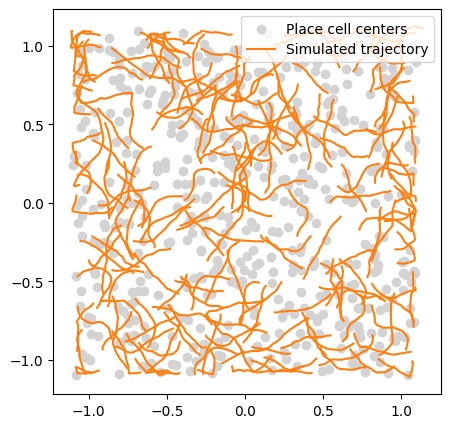

In [8]:
"""

    viz grid and trajectories

"""

us = place_cells.us.cpu() # place cells matrix

pc_inputs, position, pc_outputs = trajectory_generator.get_test_batch()
position = position.cpu()

print(f'place cells:        {us.shape}')
print(f'input velocity:     {pc_inputs[0].shape}')
print(f'input activation:   {pc_inputs[1].shape}')
print(f'input positions:    {position.shape}')
print(f'place cells output: {pc_outputs.shape}')

plt.figure(figsize=(5,5))
plt.scatter(us[:,0], us[:,1], c='lightgrey', label='Place cell centers')

for i in range( position.shape[1] ):
    plt.plot( position[:,i,0], position[:,i,1], label='Simulated trajectory', c='C1')
    if i==0:
        plt.legend();

place cell outputs: torch.Size([4000, 512])
place cell grid: (4000, 32, 32)


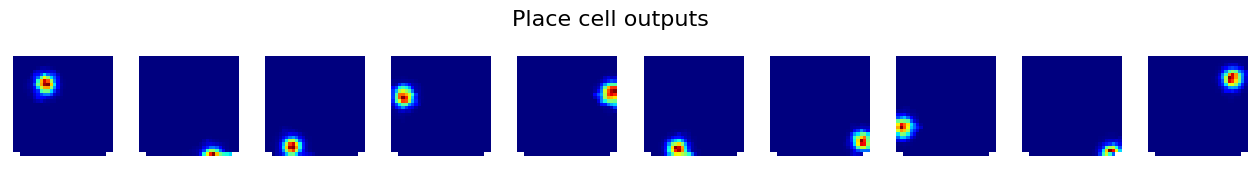

In [9]:
"""

    place cell output

"""

pc_outputs = pc_outputs.reshape( -1, options.Np ).detach().cpu()
pc = place_cells.grid_pc( pc_outputs )

print(f'place cell outputs: {pc_outputs.shape}')
print(f'place cell grid: {pc.shape}')

plt.figure(figsize=(16,2))

for i in range(10):
    
    plt.subplot(1, 10, i+1)
    plt.imshow( pc[i], cmap='jet' )
    plt.axis('off')
        
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

C mean: (30, 30)
C tilde: (30, 30)


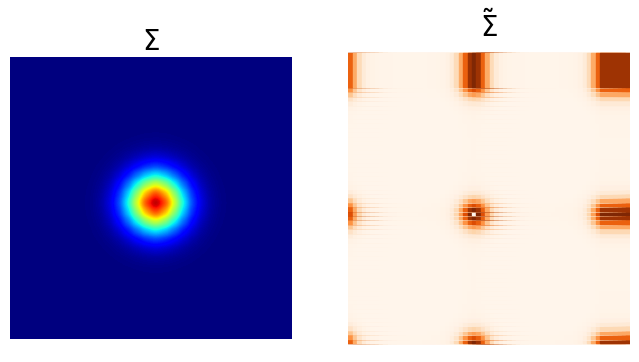

In [10]:
"""

    covariance matrix

"""

Cmean = place_cells.compute_covariance()

# Fourier transform
Ctilde = np.fft.fft2(Cmean)
Ctilde[0,0] = 0

print(f'C mean: {Cmean.shape}')
print(f'C tilde: {Ctilde.shape}')

plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(Cmean, cmap='jet', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)

width = 30
idxs = np.arange( -width + 1 , width )

x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))

plt.scatter(
    x2, 
    y2,
    c=np.abs(Ctilde)[idxs][:,idxs], 
    s=600, 
    cmap='Oranges', 
    marker='s'
)

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');

In [11]:
"""

    load model

"""

retrain = True

model = RNN(options, place_cells)

print('\n')
print('model: ')
print( model )
print('\n')

if retrain:
    
    checkpoint_file = models_path + 'example/most_recent_model_no_dog.pth'
    print(f'checkpoint file: {checkpoint_file}')
    
    checkpoint = torch.load( checkpoint_file, map_location=torch.device('cpu') )
    
    model.load_state_dict( checkpoint  )
    
else:
    
    checkpoint_file = models_path + 'example/example_trained_weights.npy'
    print(f'checkpoint file: {checkpoint_file}')

    w = np.load( checkpoint_file, allow_pickle=True )

    state_dict = {
        'encoder.weight': torch.from_numpy( w[0].T ), 
        'RNN.weight_ih_l0': torch.from_numpy( w[1].T ), 
        'RNN.weight_hh_l0': torch.from_numpy( w[2].T ), 
        'decoder.weight': torch.from_numpy( w[3].T )
    }

    model.load_state_dict( state_dict )



model: 
RNN(
  (encoder): Linear(in_features=512, out_features=4096, bias=False)
  (RNN): RNN(2, 4096, bias=False)
  (decoder): Linear(in_features=4096, out_features=512, bias=False)
  (softmax): Softmax(dim=-1)
)


checkpoint file: /Users/no_lineal/Documents/GitHub/grid-pattern-formation/models/example/most_recent_model_no_dog.pth


In [12]:
"""

    validate performance

"""

pc_inputs, position, pc_outputs = trajectory_generator.get_test_batch()

position = position.cpu()

pc_predict = model.predict( pc_inputs )

print(f'input velocity:     {pc_inputs[0].shape}')
print(f'input activation:   {pc_inputs[1].shape}')
print(f'place cell predict: {pc_predict.shape}')

pred_pos = place_cells.get_nearest_cell_pos( pc_predict ).cpu()

print(f'predicted positions: {pred_pos.shape}')

us = place_cells.us.cpu()
print(f'place cells: {us.shape}')

input velocity:     torch.Size([20, 200, 2])
input activation:   torch.Size([200, 512])
place cell predict: torch.Size([20, 200, 512])
predicted positions: torch.Size([20, 200, 2])
place cells: torch.Size([512, 2])


(-1.1, 1.1)

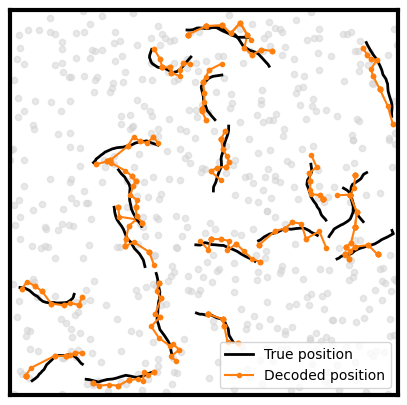

In [13]:
"""

    viz predicted positions

"""

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)

for i in range(20):
    plt.plot( position[:,i,0], position[:,i,1], c='black', label='True position', linewidth=2 )
    plt.plot( pred_pos[:,i,0], pred_pos[:,i,1], '.-',
             c='C1', label='Decoded position')
    if i==0:
        plt.legend()

plt.scatter( us[:,0], us[:,1], s=20, alpha=0.5, c='lightgrey' )

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    
plt.xticks([])
plt.yticks([])
plt.xlim([-options.box_width/2,options.box_width/2])
plt.ylim([-options.box_height/2,options.box_height/2])

place cells outputs: torch.Size([4000, 512])
place cells outputs grid: (4000, 32, 32)
place cells predict grid: (4000, 32, 32)


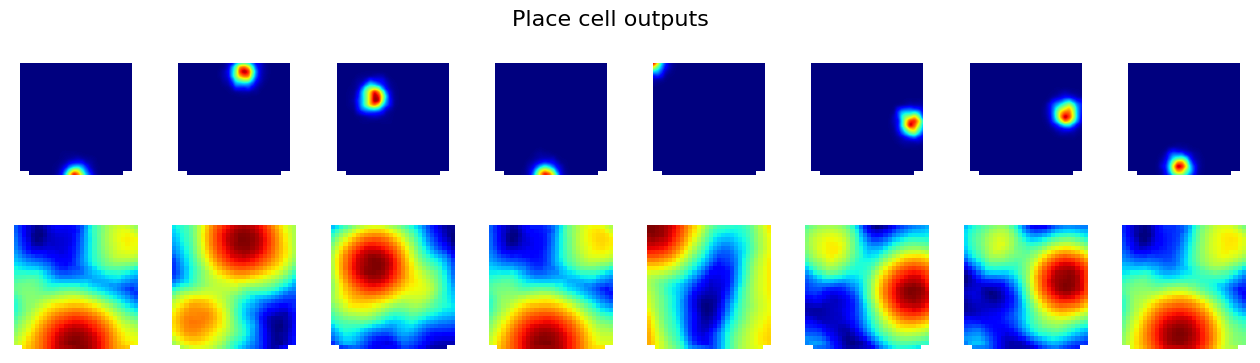

In [14]:
"""

    viz predicted place cell outputs

"""

pc_outputs_sm = model.softmax( pc_outputs ).reshape( -1, options.Np ).cpu()

pc_outputs_grid = place_cells.grid_pc( pc_outputs )
pc_predict_grid = place_cells.grid_pc( pc_predict.detach() )

print(f'place cells outputs: {pc_outputs_sm.shape}')
print(f'place cells outputs grid: {pc_outputs_grid.shape}')
print(f'place cells predict grid: {pc_predict_grid.shape}')

plt.figure(figsize=(16,4))
    
for i in range(8):
    
    plt.subplot(2,8,i+1)
    plt.imshow(pc_outputs_grid[2*i], cmap='jet', interpolation='gaussian')
    
    if i==0:
        plt.ylabel('True')
        
    plt.axis('off')
    
for i in range(8):
    
    plt.subplot(2, 8, i+9)
    plt.imshow(pc_predict_grid[2*i], cmap='jet')
    
    if i==0:
        plt.ylabel('Predicted')
        
    plt.axis('off')
    
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 3864.12it/s]


(-0.5, 859.5, 859.5, -0.5)

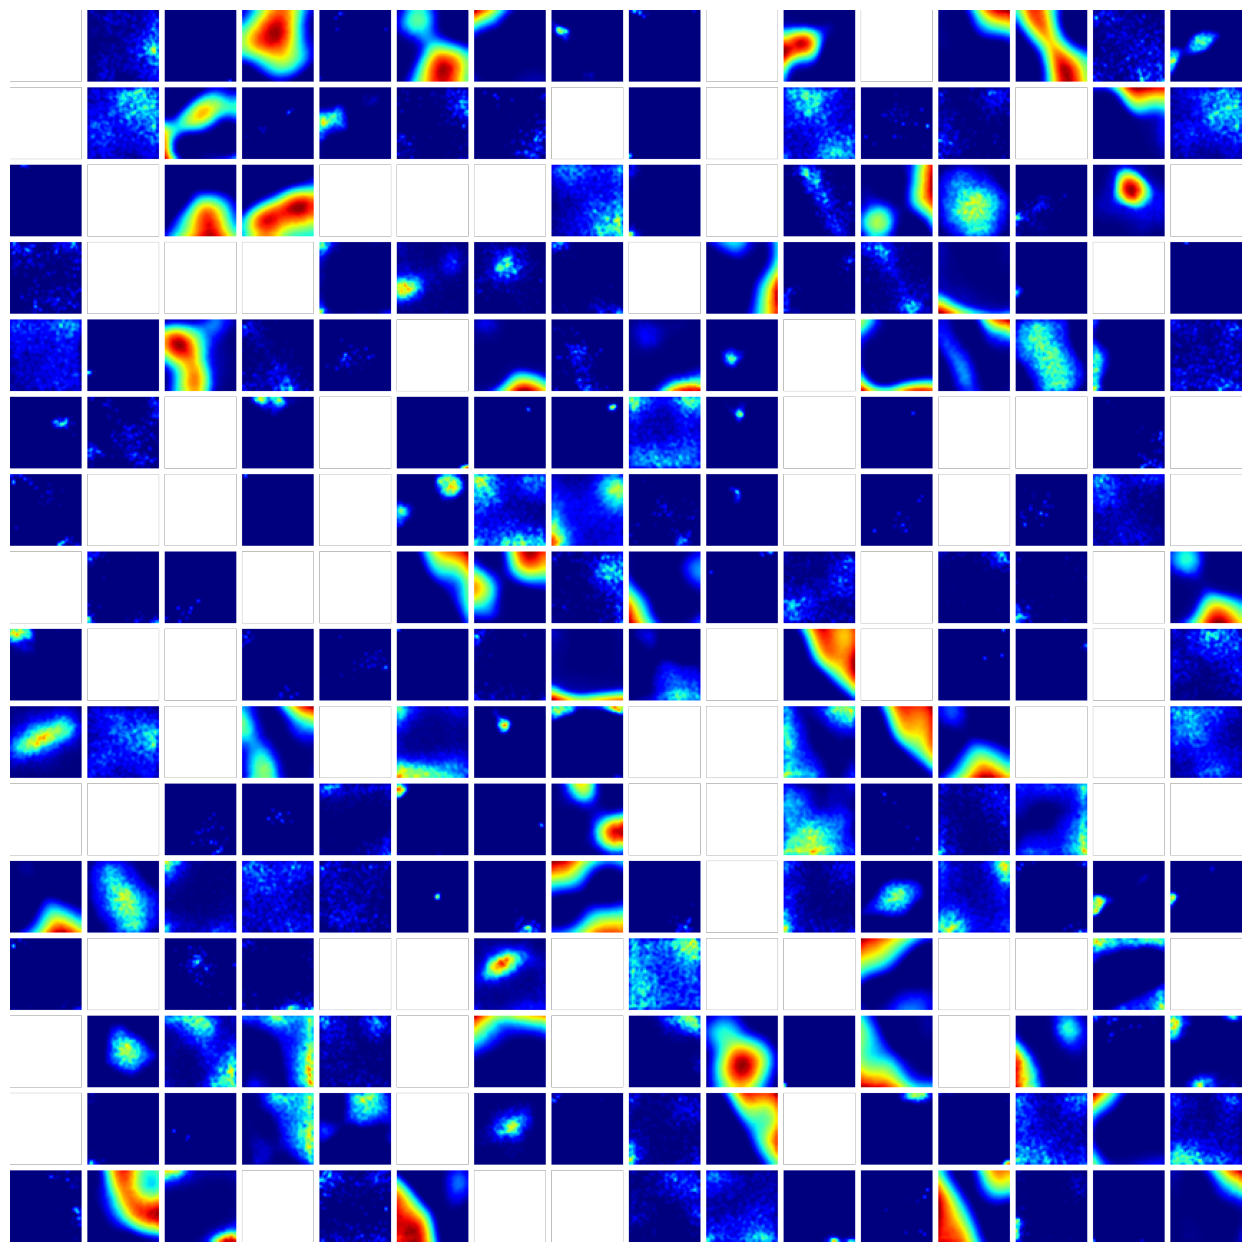

In [15]:
"""

    ratemaps

"""

res = 50
n_avg = 100
Ng = options.Ng

activations, rate_map, g, pos = compute_ratemaps(
    model, 
    trajectory_generator, 
    options, 
    res=res, 
    n_avg=n_avg, 
    Ng=Ng
)

# Compute a set of lo-res maps to use for evalutaing grid score
lo_res = 20
_, rate_map_lores, _, _ = compute_ratemaps(
    model,
    trajectory_generator, 
    options, 
    res=lo_res,
    n_avg=n_avg, 
    Ng=Ng
)

n_plot = 256
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off')

In [16]:
"""

    grid scores

"""

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)

box_width = options.box_width
box_height = options.box_height

coord_range = ((-box_width/2, box_width/2), (-box_height/2, box_height/2))
masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(res, coord_range, masks_parameters)

score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip( * [ scorer.get_scores( rm.reshape( res, res ) ) for rm in tqdm(rate_map) ] )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [13:17<00:00,  5.14it/s]


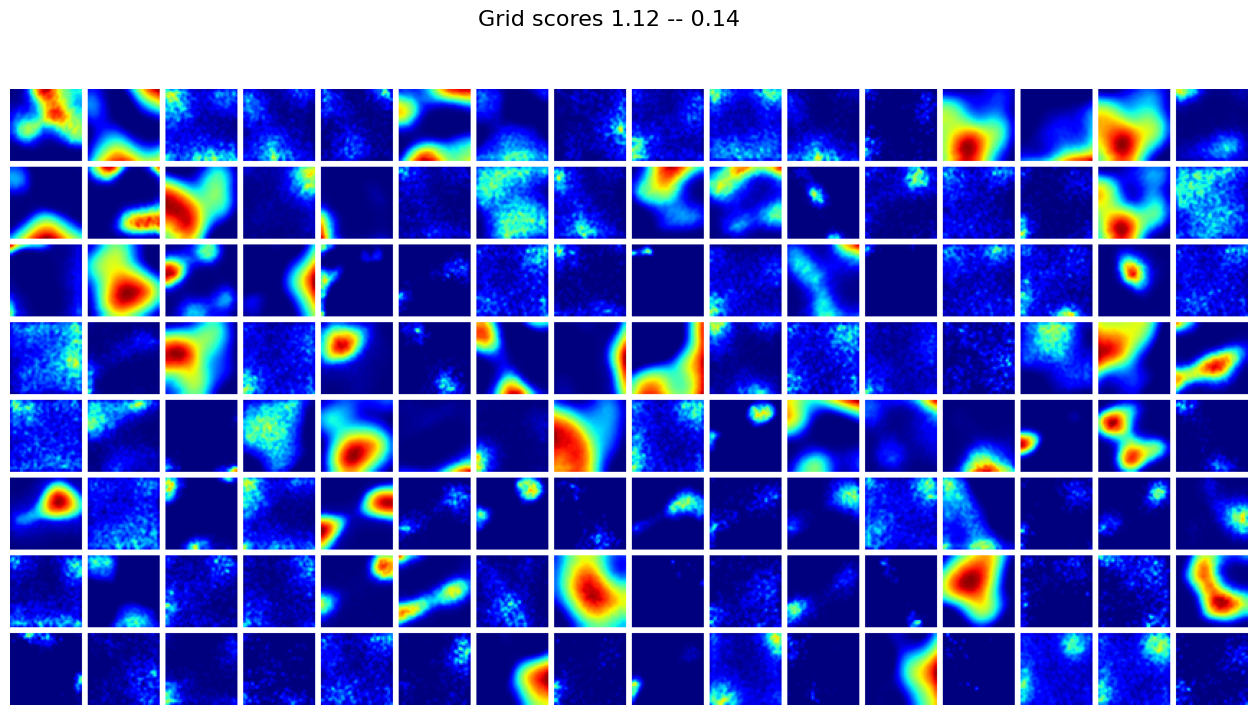

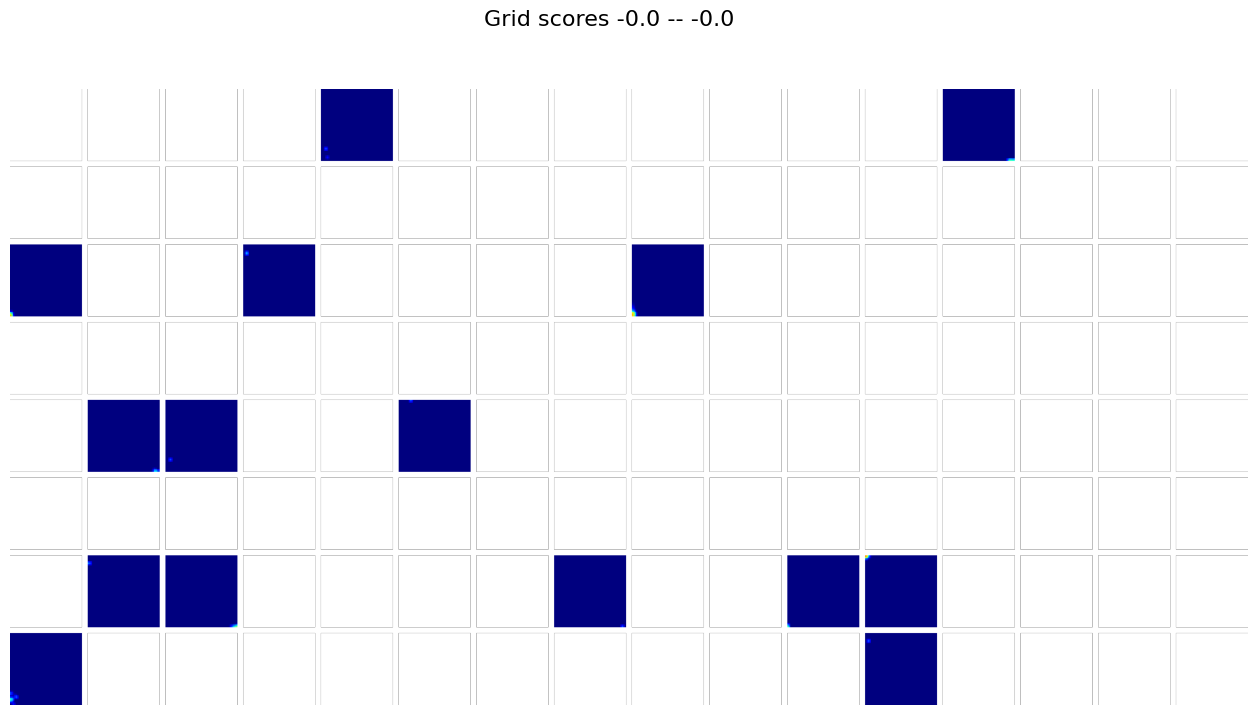

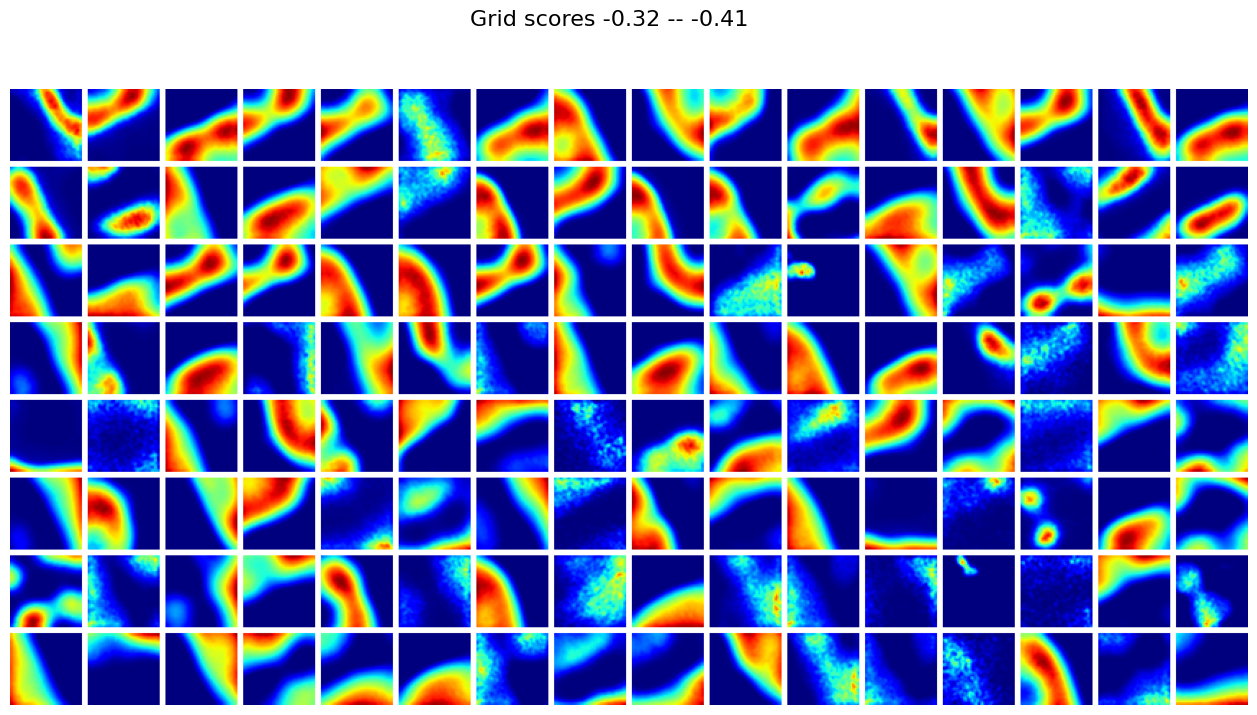

In [17]:
idxs = np.flip(np.argsort(score_60))
Ng = options.Ng

# Plot high grid scores
n_plot = 128
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[0]], 2))
             +' -- '+ str(np.round(score_60[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot medium grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs[Ng//4:]], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[Ng//2]], 2))
             +' -- ' + str(np.round(score_60[idxs[Ng//2+n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot low grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[np.flip(idxs)], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[-n_plot]], 2))
             +' -- ' + str(np.round(score_60[idxs[-1]], 2)),
            fontsize=16)
plt.axis('off');